In [ ]:
import xgboost
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
from sklearn import preprocessing
import pandas as pd
import torch
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from torch.autograd import Variable

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Mounted at /content/drive/
20_clubs_all_params_lstm.csv	   50_clubs_all_params_lstm.csv
25_clubs_xgb.csv		   50_clubs_xgb_lstm.csv
30_clubs_xgb.csv		   5_clubs_all_params_lstm.csv
50_clubs_all_params_full_lstm.csv  all_clubs_xgb.csv


# **Загрузка и предобработка данных**

In [ ]:
data = pd.read_csv("fitness_dataset.csv")
data_clean = data.loc[data["extended"] != 2]
data_clean = data_clean.fillna(0)
data_sex = pd.get_dummies(data_clean["sex"])
data_clean = pd.concat((data_clean, data_sex), axis=1)
data_limitations = pd.get_dummies(data_clean["contract_limitations"])
data_clean = data_clean.drop(["sex"], axis=1)
data_clean = data_clean.drop(["female"], axis=1)
data_clean = data_clean.rename(columns={"male": "sex"})
data_clean = pd.concat((data_clean, data_limitations), axis=1)
data_clean = data_clean.drop(["contract_limitations"], axis=1)
data_clean = data_clean.drop(["unlimited"], axis=1)
data_clean = data_clean.rename(columns={"limited": "contract_limitations"})
params = data_clean[
    ["contract_duration", "is_discounted", "contract_limitations",
     "age", "sex", "contracts_before", "visits_per_month",
     "v_sum2mdiv", "v_sum1mdiv", "v_sum2wdiv", "v_sum1wdiv", "v_sum4mdiv",
     "dur2mdiv", "dur1mdiv", "dur2wdiv", "dur1wdiv", "dur4mdiv",
     "spend2mdiv", "spend1mdiv", "spend2wdiv", "spend1wdiv", "spend4mdiv"
     ]]
#params = data_clean[
#    ["contract_duration", "is_discounted", "contract_limitations",
#     "age", "sex", "contracts_before", "visits_per_month",
#     "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
#     "15", "16", "17"
#     ]]
target = data_clean[["extended"]]
X_train, X_test, y_train, y_test = train_test_split(
    params,
    target,
    test_size=0.2,
    shuffle=True)

print(len(X_train))
print(len(X_test))

221925
55482


# **XGBOOST**

Обучение и результаты

              precision    recall  f1-score   support

           0       0.72      0.60      0.66     20334
           1       0.79      0.86      0.82     35148

    accuracy                           0.77     55482
   macro avg       0.75      0.73      0.74     55482
weighted avg       0.76      0.77      0.76     55482



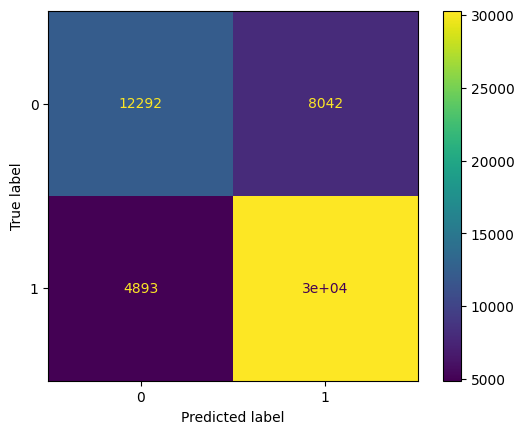

In [ ]:
f1_scores = []

model = xgboost.XGBClassifier(tree_method="hist", enable_categorical=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
f1_scores.append(cr['weighted avg']['f1-score'])
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
# print(model.get_booster().get_score(importance_type='gain'))

# **Полносвязная нейронная сеть**

In [ ]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

device = torch.device('cuda:0'
                      if torch.cuda.is_available()
                      else 'cpu')

Архитектура сети

In [ ]:
class MyFCNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MyFCNet, self).__init__()

        self.fc1 = torch.nn.Linear(22, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.sm(x)
        return x

Обучение

In [ ]:
my_net = MyFCNet(50)

loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(my_net.parameters(),
                             lr=0.001)
batch_size = 10000

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = my_net(x_batch)
        # print(preds)
        loss_value = loss(preds, y_batch.reshape(-1,1))
        loss_value.backward()

        optimizer.step()

    if epoch % 100 == 0:
        test_preds = my_net(X_test)
        print((test_preds.round() == y_test).float().mean())

tensor(0.6608)
tensor(0.7395)
tensor(0.7442)
tensor(0.7471)
tensor(0.7508)
tensor(0.7532)
tensor(0.7538)
tensor(0.7542)
tensor(0.7559)
tensor(0.7513)


Результаты

              precision    recall  f1-score   support

         0.0       0.70      0.58      0.64     20334
         1.0       0.78      0.86      0.82     35148

    accuracy                           0.76     55482
   macro avg       0.74      0.72      0.73     55482
weighted avg       0.75      0.76      0.75     55482



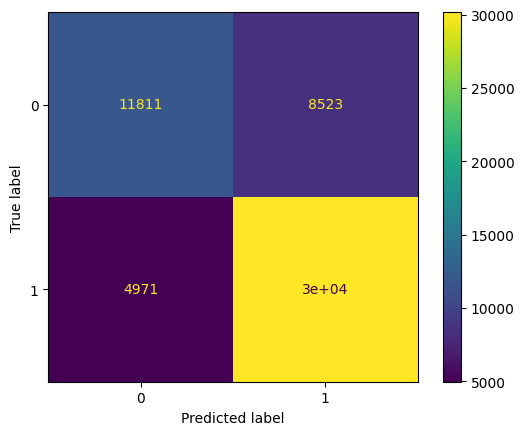

In [ ]:
MY_prediction = my_net.forward(X_test)
threshold = 0.5
res = (MY_prediction >= threshold).float()
cr = classification_report(y_test, res, output_dict=True)
print(classification_report(y_test, res))
f1_scores.append(cr['weighted avg']['f1-score'])
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, res))
disp.plot()

# **Нейронная сеть с LSTM слоем**

Добавлеие понедельных данных о посещениях

In [ ]:
params = data_clean[
    ["contract_duration", "is_discounted", "contract_limitations",
     "age", "sex", "contracts_before", "visits_per_month",
     "v_sum2mdiv", "v_sum1mdiv", "v_sum2wdiv", "v_sum1wdiv", "v_sum4mdiv",
     "dur2mdiv", "dur1mdiv", "dur2wdiv", "dur1wdiv", "dur4mdiv",
     "spend2mdiv", "spend1mdiv", "spend2wdiv", "spend1wdiv", "spend4mdiv",
     "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
     "15", "16", "17"
     ]]
target = data_clean[["extended"]]
X_train, X_test, y_train, y_test = train_test_split(
    params,
    target,
    test_size=0.2,
    shuffle=True)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

Архитектура сети

In [ ]:
class MyLSTMNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons, lstm_hidden, num_lstm_layers):
        super(MyLSTMNet, self).__init__()
        self.n_hidden_neurons = n_hidden_neurons
        self.lstm_hidden = lstm_hidden
        self.num_lstm_layers = num_lstm_layers

        self.lstm_visits = torch.nn.LSTM(input_size=17, hidden_size=lstm_hidden,
                          num_layers=num_lstm_layers)

        self.activ_lstm_vis = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(22 + lstm_hidden, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Sigmoid()



    def forward(self, x):
        x_vis = Variable(x[:, 22:])
        x_vis_reshape = torch.reshape(x_vis, (1, x_vis.shape[0], x_vis.shape[1]))
        self.lstm_visits.flatten_parameters()
        output, (hn_vis, cn_vis) = self.lstm_visits(x_vis_reshape) #lstm with input, hidden, and internal state
        hn_vis = hn_vis.view(-1, self.lstm_hidden) #reshaping the data for Dense layer next
        out_lstm_vis = self.activ_lstm_vis(hn_vis)

        #print(out_lstm_vis.shape)
        #print(out_fc1.shape)
        concat = torch.cat((out_lstm_vis, x[:, :22]), dim = -1)

        out = self.activ1(self.fc1(concat))
        out = self.activ2(self.fc2(out))
        out = self.fc3(out)
        return self.sm(out)

Обучение

In [ ]:
my_net = MyLSTMNet(50, 4, 1)

loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(my_net.parameters(),
                             lr=0.001)
batch_size = 10000

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = my_net.forward(x_batch)
        # print(preds)
        loss_value = loss(preds, y_batch.reshape(-1,1))
        loss_value.backward()

        optimizer.step()

    if epoch % 100 == 0:
        test_preds = my_net(X_test)
        print((test_preds.round() == y_test).float().mean())

tensor(0.6887)
tensor(0.7644)
tensor(0.7677)
tensor(0.7728)
tensor(0.7759)
tensor(0.7755)
tensor(0.7790)
tensor(0.7780)
tensor(0.7784)
tensor(0.7806)


Результаты

              precision    recall  f1-score   support

         0.0       0.73      0.64      0.68     20443
         1.0       0.80      0.86      0.83     35039

    accuracy                           0.78     55482
   macro avg       0.77      0.75      0.76     55482
weighted avg       0.78      0.78      0.78     55482



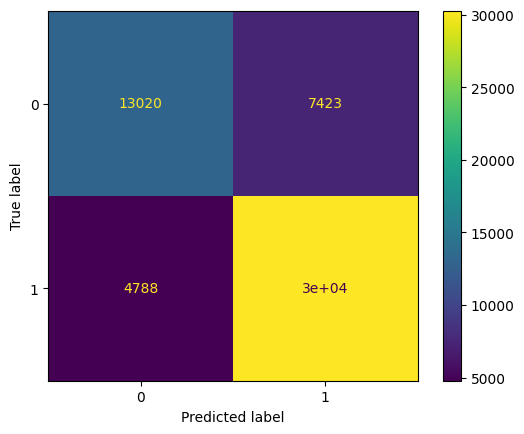

In [ ]:
MY_prediction = my_net.forward(X_test)
threshold = 0.5
res = (MY_prediction >= threshold).float()
print(classification_report(y_test, res))
cr = classification_report(y_test, res, output_dict=True)
f1_scores.append(cr['weighted avg']['f1-score'])
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, res))
disp.plot()

# **Сравнение моделей**

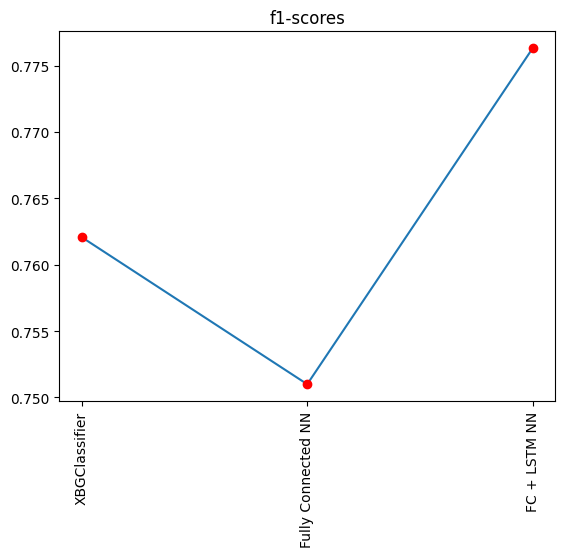

In [ ]:
import matplotlib.pyplot as plt

plt.plot(["XBGClassifier", "Fully Connected NN", "FC + LSTM NN"], f1_scores)
plt.plot(["XBGClassifier", "Fully Connected NN", "FC + LSTM NN"], f1_scores, 'or')
plt.xticks(rotation=90)
plt.title('f1-scores')
plt.show()